In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime

In [7]:
import torch
num_features = 3
future_steps = 4
nysm_vars = 2

# Create a sample tensor
x = np.random.randn(6, 12, 8)
print(x)

[[[ 0.2294319   1.21966059 -1.62704249  1.10043508 -0.8619838
   -0.32140691 -0.51238723  1.57261772]
  [ 0.73297796  0.05365898 -0.71628356  0.17963831 -0.63742035
   -0.58568945  1.73158969 -0.49180277]
  [-1.25335083 -1.35934608 -0.46281226 -0.29032647 -0.56817232
    0.46884381 -1.07609395 -1.27978874]
  [ 0.12490609 -0.8874571   0.40585545  0.25191288  0.52199409
   -0.48725182  1.8252066  -0.59258337]
  [-0.80812283  0.99683326  0.25968142 -1.14684979  0.21782252
   -0.60818792 -1.62595019  2.31457671]
  [ 1.78117436  0.86222756 -1.16186022 -1.02480203  0.99188841
   -1.03234332 -0.04282558  0.47224641]
  [-0.68192853 -0.95081438  0.29240363  0.90034799 -0.77754515
    0.05151975 -1.47448089  0.4007543 ]
  [ 0.84139457  0.39058767 -0.93756021  0.18633415  0.57761245
   -0.65827202  0.00325383  0.07658517]
  [ 0.79946032  1.01310653  0.1741826   1.99071141  1.20552812
   -0.24952533 -0.53653074 -2.91890274]
  [ 2.39896351 -0.1637645  -0.48926155 -0.72256554  0.79057318
   -0.52760

In [12]:
x[:, -future_steps:, -nysm_vars:] = np.expand_dims(x[:,-future_steps,:-nysm_vars], axis=1)
print(x)

ValueError: could not broadcast input array from shape (6,1,6) into shape (6,4,2)

In [2]:
model_path = "/home/aevans/convLSTM/src/data/temp_df/20240331/Mohawk Valley/20240331_21:34_ml_output.parquet"

clim_div = 'Mohawk Valley'

full_df_path = '/home/aevans/convLSTM/src/data/temp_df/20240331/Mohawk Valley/Mohawk Valley_CAMD.parquet'

In [3]:
nysm_cats_path = "/home/aevans/nwp_bias/src/landtype/data/nysm.csv"
nysm_cats_df = pd.read_csv(nysm_cats_path)
stations = nysm_cats_df[nysm_cats_df['climate_division_name']==clim_div]['stid'].unique()
stations

array(['CAMD', 'HERK', 'JOHN', 'OPPE', 'SPRA', 'WEST'], dtype=object)

In [4]:
df = pd.read_parquet(model_path)
df = df.sort_index()

In [5]:
df

,0_convLSTM_output,0_target,1_convLSTM_output,1_target,2_convLSTM_output,2_target,3_convLSTM_output,3_target,4_convLSTM_output,4_target,5_convLSTM_output,5_target
0,0.362334,-0.314755,-0.270989,0.027452,-0.127686,-0.534891,0.325600,0.609343,-0.158865,-1.384741,-0.470795,-1.533985
1,0.010767,-0.647333,-0.600394,0.316203,-0.605578,-1.099413,0.294682,0.595250,-0.311131,-1.958878,0.229691,-1.747250
2,-0.206533,-0.167850,-0.341923,0.263237,-0.373595,-0.091111,-0.021987,-0.140074,-0.536775,-1.297019,-0.595300,-1.788382
3,-0.493249,-0.483740,0.580472,0.380887,-0.140343,-0.044857,-0.355309,1.576964,0.207495,-0.926346,-0.488287,-0.159364
4,0.394349,2.301675,-0.114271,0.451185,-0.162265,0.074448,0.309520,0.892727,0.485891,0.769951,-0.203350,-0.180089
...,...,...,...,...,...,...,...,...,...,...,...,...
48542,-0.176092,-0.610262,-0.269600,-0.351226,-0.587678,-0.769265,0.274926,0.083325,-0.563981,-0.563675,-0.056026,-0.049682
48543,-0.351098,-1.094895,-0.255116,-1.164314,-0.475139,-0.745370,0.248047,-0.200732,-0.598495,-0.698523,-0.141971,-0.564140
48544,-0.499877,-1.268585,-0.288675,-1.550458,-0.378391,-0.987515,-0.004335,-0.678765,-0.653765,-1.117133,0.021102,-0.757786
48545,-0.583059,-1.173881,-0.274267,-1.503778,-0.433585,-0.725308,-0.420718,-0.630712,-0.677120,-1.429067,-0.037866,-0.780501


In [6]:
full_df = pd.read_parquet(full_df_path)

In [7]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]

    return df_train['valid_time'], df_test['valid_time']

In [8]:
df_train, df_test = which_fold(full_df, 3)

In [9]:
df_test.iloc[0]

Timestamp('2021-07-19 01:00:00')

In [10]:
df_test.iloc[-1]

Timestamp('2022-09-18 12:00:00')

In [11]:
vt = full_df['valid_time'].to_list()
vt = vt[:int(len(df)-len(full_df))]
df['valid_time'] = vt

In [12]:
df = df[df['valid_time'] > datetime(2021, 9, 1, 0, 0, 0)]
df = df[df['valid_time'] < datetime(2021, 9, 30, 23, 0, 0)]
#df = df.drop(columns='valid_time')

In [13]:
def plot_outputs(df_out, clim_div, stations):
    import matplotlib.pyplot as plt 
    df_out = df_out.sort_index()
    fig, axs = plt.subplots(int(df_out.shape[1]/2), figsize=(21, 21), sharex=True, sharey=True)
    n = int(df_out.shape[1]/2)
    i = 0
    while n>i:
        axs[i].set_ylabel(f'{stations[i]}')
        axs[i].plot(df_out['valid_time'], df_out[f'{i}_target'], c="r", label="Target")
        axs[i].plot(df_out['valid_time'], df_out[f"{i}_convLSTM_output"], c="b", alpha=0.7, label="convLSTM Output")
        
        print(f"Mean Absolute Difference of {stations[i]}: {abs(df_out[f'{i}_target'] - df_out[f'{i}_convLSTM_output']).mean()}")
        i+=1
    fig.suptitle(f"convLSTM Output v Target", fontsize=28)
    axs[0].legend()
    plt.tight_layout()

Mean Absolute Difference of CAMD: 0.6358029974739378
Mean Absolute Difference of HERK: 0.6677549167311948
Mean Absolute Difference of JOHN: 0.6773274938021849
Mean Absolute Difference of OPPE: 0.6186148134329202
Mean Absolute Difference of SPRA: 0.6086771365804003
Mean Absolute Difference of WEST: 0.6177965535527644


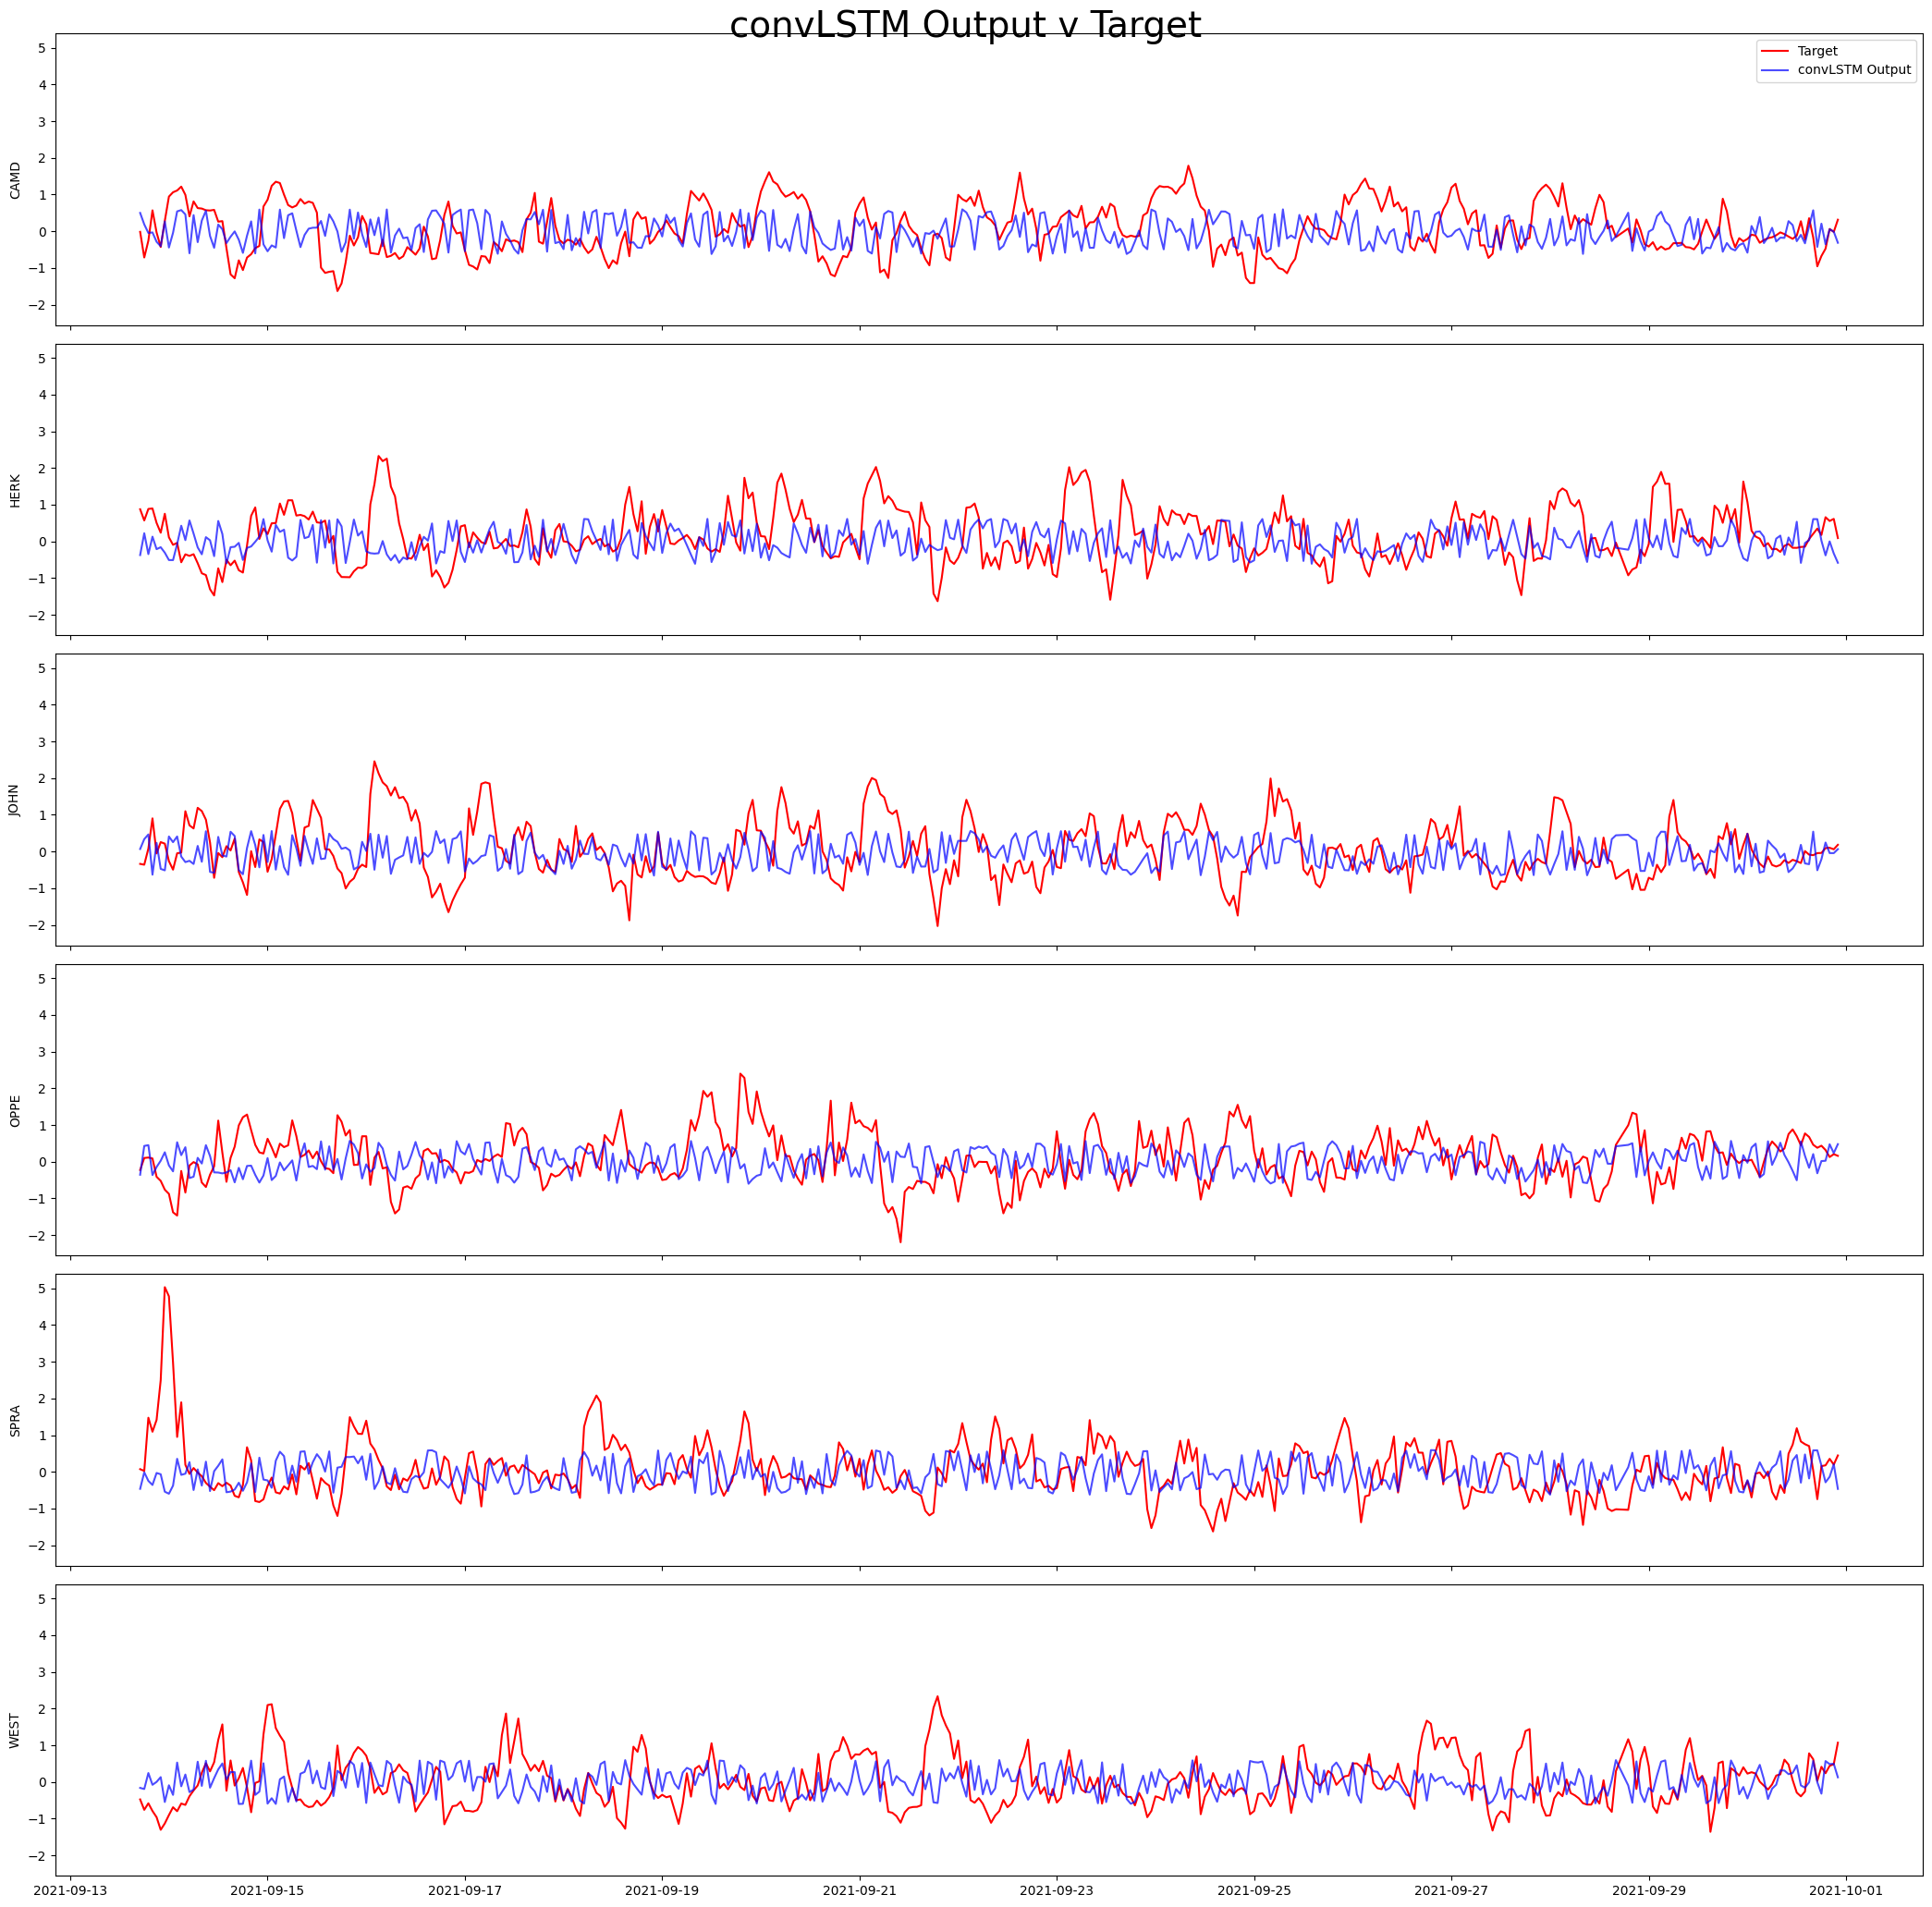

In [14]:
plot_outputs(df, clim_div, stations)